# 経済指標

In [2]:
import pandas as pd
import datetime
# from newspaper import Article
import time
import re
import datetime
import numpy as np
import lxml.html

In [3]:
def get_df(url, date):
    url_date = url + date
    df = pd.read_html(url_date)
    df = df[0].dropna(subset = [4]).drop(2,axis =1)
    df.columns = ["発表時刻", "経済指標", "前回変動幅(USD/JPY)","前回","予想","結果"]
    df["日付"] = date
    return df

In [4]:
def str2num(text):
    '''
    表中の単位付きデータから数値を抜き出す
    データのカラムにapplyする
    かっこの中身を優先して読み取る。（速報値用）
    args:
        text: string or int or float
    return:
        num: float
    '''
    if((type(text) == int) or (type(text) == float)):
        return text
    if len(text.split('（')) == 2:
        text = text.split('（')[1]
    pattern = '[+]?[-]?[0-9]+[.]?[0-9]+?'
    result = re.match(pattern, text)
    if result == None:
        return 0
    return  float(text[result.start():result.end()])

In [5]:
def inv_del_dup(df):
    '''
    データを古い順番に並べ替えて、重複データを削除する。
    新しい順だと新しいデータが残ってしまう。
    args:
        df: pd.DataFrame, columns = ['発表時刻', '経済指標', '前回変動幅(USD/JPY)', '前回', '予想', '結果', '日付']
    return:
        df: reversed, del duplicates
    '''
    df = df.reset_index(drop=True)
    cols = df.columns
    idx = list(df.index.values)
    idx.reverse()
    
    def inv_bool(a):
        if a == False:
            return True
        else:
            return False
    
    df_rev = df.iloc[idx].reset_index(drop=True)
    return df_rev[df_rev[cols[:-1]].duplicated().apply(inv_bool)].reset_index(drop=True)

In [6]:
def datetime_merge(d, t):
    dt = d + " " + t
    return datetime.datetime.strptime(dt, '%Y-%m-%d %H:%M')

In [7]:
def indicators(text):
    '''
    経済指標を成型して、指標を取り出す。
    '''
    if len(text.split('[')) > 1:
        return "-"
    return text.split(' ')[0]
    
def ind_filter(df, ind):
    '''
    指定した指標、国名のデータを取り出す。
    '''
    return df[df['経済指標'].str.contains(ind, na=False)]

In [9]:
N = 820
pdf = pd.DataFrame()
for i in range(N):
    date = datetime.date(2021, 4, 1) - datetime.timedelta(days=i)
    date = date.strftime('%Y-%m-%d')
    url = f'https://fx.minkabu.jp/indicators?date='
    pdf_date = get_df(url, date)
    pdf = pd.concat([pdf, pdf_date], axis=0)
    time.sleep(0.1)
pdf = pdf.reset_index(drop=True)

<AxesSubplot:>

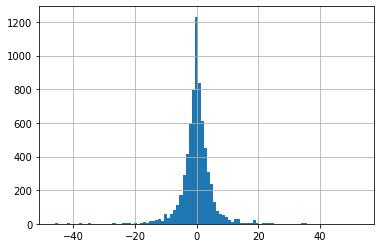

In [46]:
pdf.dropna()['前回変動幅(USD/JPY)'].apply(lambda x :float(x.split('pips')[0]) if x != '---' else 0).hist(bins=100)

In [11]:
file_name = 'fx_indicators.csv' 
pdf.to_csv(file_name, index=False)
# pdf = pd.read_csv(file_name)
# del pdf['Unnamed: 0']

In [48]:
pdf

,発表時刻,経済指標,前回変動幅(USD/JPY),前回,予想,結果,日付
0,06:30,豪・AiG製造業指数 03月,---,58.8,---,59.9,2021-04-01
1,08:50,日本・日銀短観 第1四半期 [大企業製造業・業況判断],+2.9pips,-10,-1,5,2021-04-01
2,08:50,[日銀短観（大企業製造業・先行き）],NaN,-8,4,4,2021-04-01
3,08:50,[大企業非製造業・業況判断],NaN,-5,-4,-1,2021-04-01
4,08:50,[大企業非製造業・先行き],NaN,-6,-1,-1,2021-04-01
...,...,...,...,...,...,...,...
10222,17:30,香港・小売売上高 11月 [前年比],-1.2pips,5.9% （6.0%）,4.5%,1.4%,2019-01-03
10223,17:30,[前年比],NaN,5.2% （5.3%）,4.6%,1.2%,2019-01-03
10224,21:00,アメリカ・MBA住宅ローン申請指数 12/22 - 12/28,---,-1.4%,---,-8.5%,2019-01-03
10225,22:15,アメリカ・ADP雇用者数 12月,-1.2pips,17.9万人 （15.7万人）,18.0万人,27.1万人,2019-01-03


In [12]:
pdf_rev = inv_del_dup(pdf)
display(pdf_rev)

,発表時刻,経済指標,前回変動幅(USD/JPY),前回,予想,結果,日付
0,22:30,アメリカ・新規失業保険申請件数 12/23 - 12/29,+0.6pips,21.6万件 （22.1万件）,22.0万件,23.1万件,2019-01-03
1,22:15,アメリカ・ADP雇用者数 12月,-1.2pips,17.9万人 （15.7万人）,18.0万人,27.1万人,2019-01-03
2,21:00,アメリカ・MBA住宅ローン申請指数 12/22 - 12/28,---,-1.4%,---,-8.5%,2019-01-03
3,17:30,[前年比],NaN,5.2% （5.3%）,4.6%,1.2%,2019-01-03
4,17:30,香港・小売売上高 11月 [前年比],-1.2pips,5.9% （6.0%）,4.5%,1.4%,2019-01-03
...,...,...,...,...,...,...,...
8592,08:50,[大企業非製造業・先行き],NaN,-6,-1,-1,2021-04-01
8593,08:50,[大企業非製造業・業況判断],NaN,-5,-4,-1,2021-04-01
8594,08:50,[日銀短観（大企業製造業・先行き）],NaN,-8,4,4,2021-04-01
8595,08:50,日本・日銀短観 第1四半期 [大企業製造業・業況判断],+2.9pips,-10,-1,5,2021-04-01


In [13]:
ind_list = pdf['経済指標'].apply(indicators).unique()
ind_list = ind_list[(ind_list != '-')]

In [34]:
pd.Series(ind_list).apply(lambda x: x.split("・")[0])

0         豪
1         豪
2        中国
3       スイス
4       スイス
       ... 
166      英国
167       豪
168      日本
169      英国
170    アメリカ
Length: 171, dtype: object

In [22]:
ind = ind_list[10]
pdf_filtered = ind_filter(pdf_rev, ind).copy()

ind_prev_arr = pdf_filtered['前回'].apply(str2num).values
ind_result_arr = pdf_filtered['結果'].apply(str2num).values

time_arr =  pdf_filtered.apply(lambda row:datetime_merge(*row[['日付', '発表時刻']]), axis=1).values
ind_pred_arr = pdf_filtered['予想'].apply(str2num).values
ind_arr = np.hstack([ind_prev_arr[1:], (ind_result_arr[-1])])

In [23]:
pdf_filtered['date'] = pd.to_datetime(pdf_filtered['日付'] + " " + pdf_filtered['発表時刻'])
pdf_filtered = pdf_filtered.set_index('date')

<AxesSubplot:xlabel='date'>

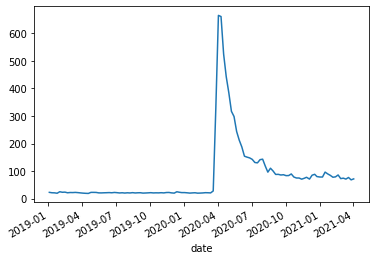

In [29]:
pdf_filtered['結果'].apply(lambda x: float(x.split('万件')[0])).plot()

In [27]:
pdf_filtered

,発表時刻,経済指標,前回変動幅(USD/JPY),前回,予想,結果,日付
date,,,,,,,
2019-01-03 22:30:00,22:30,アメリカ・新規失業保険申請件数 12/23 - 12/29,+0.6pips,21.6万件 （22.1万件）,22.0万件,23.1万件,2019-01-03
2019-01-10 22:30:00,22:30,アメリカ・新規失業保険申請件数 12/30 - 01/05,-12.6pips,23.1万件 （23.3万件）,22.6万件,21.6万件,2019-01-10
2019-01-17 22:30:00,22:30,アメリカ・新規失業保険申請件数 01/06 - 01/12,+8.0pips,21.6万件,22.0万件,21.3万件,2019-01-17
2019-01-24 22:30:00,22:30,アメリカ・新規失業保険申請件数 01/13 - 01/19,+12.7pips,21.3万件 （21.2万件）,21.8万件,19.9万件,2019-01-24
2019-01-31 22:30:00,22:30,アメリカ・新規失業保険申請件数 01/20 - 01/26,-8.0pips,19.9万件 （20.0万件）,21.5万件,25.3万件,2019-01-31
...,...,...,...,...,...,...,...
2021-03-04 22:30:00,22:30,アメリカ・新規失業保険申請件数 02/21 - 02/27,-2.1pips,73.0万件 （73.6万件）,75.0万件,74.5万件,2021-03-04
2021-03-11 22:30:00,22:30,アメリカ・新規失業保険申請件数 02/28 - 03/06,+1.8pips,74.5万件 （75.4万件）,72.5万件,71.2万件,2021-03-11
2021-03-18 21:30:00,21:30,アメリカ・新規失業保険申請件数 03/07 - 03/13,+7.5pips,71.2万件 （72.5万件）,70.0万件,77.0万件,2021-03-18
